# Analyzing the first-level results

After running our GLM analysis, we have the estimated amplitude responses of each voxel to each image class. Along with Noah Benson's anatomical template / Bayesian model, we also have each voxel's visual area and location in the visual field (in terms of eccentricity and polar angle). By combining the information contained within them, along with the dataframe describing each stimulus class, we can construct our tuning curves.

In [23]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt 
import sys
sys.path.append('..')
import sfp
import h5py
import os
import itertools
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap
from sklearn import linear_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
bids_dir = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/'
# d = sfp.utils.load_data('wlsubj001', 'pilot01', atlas_type='prior', df_mode='full')
ds = sfp.utils.load_data('wlsubj045', 'ses-04', atlas_type='posterior', df_mode='summary', mat_type='stim_class', eccen_bin=False, bids_dir=bids_dir)
#full_ds = sfp.utils.load_data('wlsubj045', 'ses-04', atlas_type='posterior', df_mode='full', mat_type='stim_class', eccen_bin=True, bids_dir=bids_dir)
#full_ds_old = sfp.utils.load_data('wlsubj045', 'ses-02', atlas_type='posterior', df_mode='full', mat_type='stim_class', eccen_bin=True, bids_dir=bids_dir)
#full_ds_new = sfp.utils.load_data('wlsubj045', 'ses-03', atlas_type='posterior', df_mode='full', mat_type='stim_class', eccen_bin=True, bids_dir=bids_dir)
# ds2 = sfp.utils.load_data('wlsubj001', 'ses-pilot01', atlas_type='prior', df_mode='summary',mat_type='stim_class')
ds_64 = sfp.utils.load_data('wlsubj064', 'ses-04', atlas_type='posterior', df_mode='full', mat_type='stim_class', eccen_bin=True, bids_dir=bids_dir)

Here we see the different stimulus classes, as plotted in frequency space, colored by their superclass. These numbers are roughly log-spaced (doubling).

We also, in order to double-check some of our calculations, plot the distance and angle in frequency space: they look exactly correct.

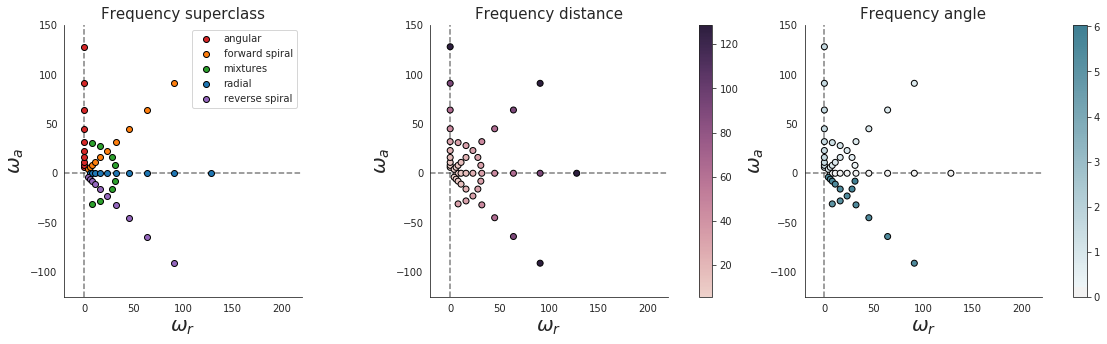

In [3]:
_=sfp.plotting.stimuli_properties(ds['df'])

We also now plot the local spatial frequency as a function of eccentricity, separately for each stimulus class and distance in frequency space. If we created our stimuli correctly, the local spatial frequency should depend on frequency space distance and eccentricity, but not on stimulsu superclass, so lines of the same color should be identical in each of the following facets

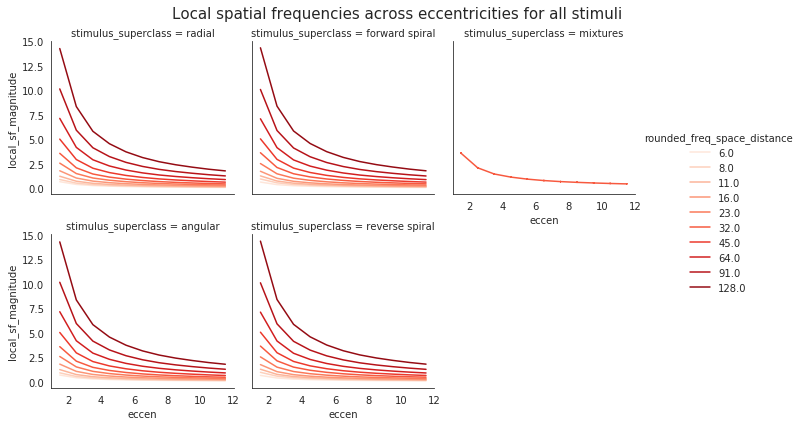

In [4]:
_=sfp.plotting.local_spatial_frequency(ds['df'])

In order to double-check that we're getting the local spatial frequency calculation correct, we also have the ability to plot linear a linear approximation of the stimuli. We first plot a windowed view of the actual stimulus we presented (so it's the same grating, just with apertures showing windowed views). We then compare this with a "windowed linear approximation": for each of the apertures in the first figure, we plot a linear approximation of the grating there (based on the phase and the local spatial frequency). If we calculated thigns correctly, this should look approximately correct and will look closer and closer to the actual grating the more windows we have (though increasing the number of windows will also increase the amount of time it takes to create this figure).

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/pandas/core/generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


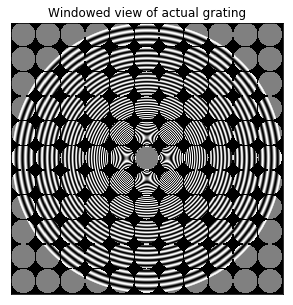

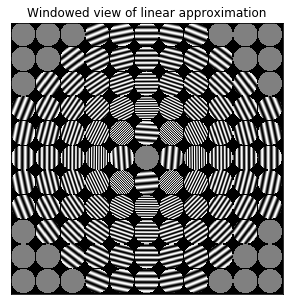

In [5]:
_ = sfp.plotting.stimuli_linear_approximation(ds['stim'], ds['stim_df'], ds['stim_type'], num_windows=11, freq_space_distance=181, phi=np.pi/4, stimulus_superclass='radial')

In [6]:
Rmin, Rmax = sfp.first_level_analysis.find_ecc_range_in_degrees(ds['stim'][0], 12)
print("Inside radius of stimulus annulus: %.02f" % Rmin)
print("Outside radius of stimulus annulus: %.02f" % Rmax)

Inside radius of stimulus annulus: 0.96
Outside radius of stimulus annulus: 12.00


Now that we've looked at a couple of stimulus properties and double-checked that everything looks correct, we can start looking at the results of GLMdenoise.

We can first look at the $R^2$ values of the fit. Note that this looks a little weird, because right now we're only looking at V1, V2, and V3 and we're binning by eccentricity. Therefore the $R^2$ values will have a really strange distribution.

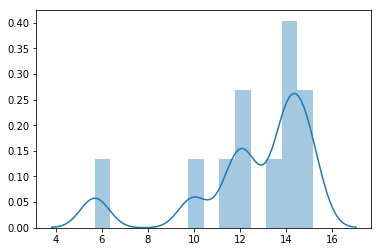

In [7]:
sns.distplot(ds['df'].R2.values)

Below is an example to show what the data roughly look like. We plot the spatial response as a function of local spatial frequency at three different eccentricities in V1 for the four main stimulus classes. We see they look like they could generally be fit by log-normal tuning curves.

The points are the median, while the error bars represent the 68% confidence intervals, as grabbed from the bootstraps produced by GLMdenoise.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


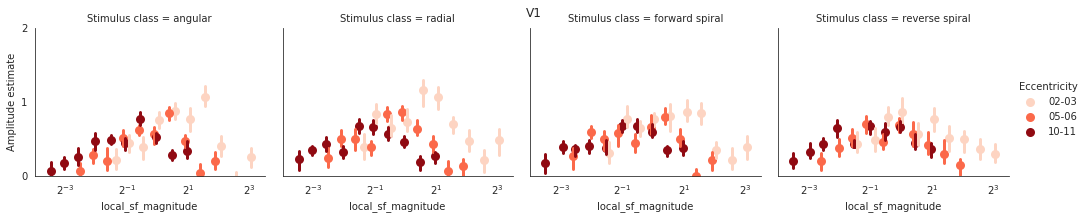

In [8]:
first_level_df = full_ds['df']
first_level_df = first_level_df[(first_level_df.varea==1)&(first_level_df.eccen.isin(['02-03', '05-06', '10-11']))&(first_level_df.stimulus_superclass.isin(['radial', 'angular', 'forward spiral', 'reverse spiral']))]
with sns.axes_style('white'):
    palette = [sns.color_palette("Reds", 11)[1]] + [sns.color_palette("Reds", 11)[5]] + [sns.color_palette("Reds", 11)[10]]
    g = sns.FacetGrid(first_level_df, hue='eccen', palette=palette, size=3, col='stimulus_superclass', ylim=(0,4), xlim=(2**-4, 2**3.5), aspect=1.2,)
    #g.map_dataframe(sfp.plotting.plot_median, "Local spatial frequency (cpd)", 'amplitude_estimate', linewidth=6)
    g.map_dataframe(sfp.plotting.scatter_ci_dist, 'local_sf_magnitude', 'amplitude_estimate', linewidth=3)
    for ax in g.axes.flatten():
        ax.set_xscale('log', basex=2)
    g.set_yticklabels([0, '', 1, '', 2, '', 3, '', 4])
    g.set(xticks=[2**-3, 2**-1, 2**1, 2**3])
    g.add_legend()
    g._legend.set_title("Eccentricity")
    g.set_ylabels("Amplitude estimate")
    g.set_titles("Stimulus class = {col_name}")
    g.fig.suptitle("V1")

Below is a more complete representation fo all this data (note that this lines are just connecting the data and serve to help you group them, they're not a function fit or anything). To simplify how they're presented, the x-axis here is the distance in frequency space, rather than the local spatial frequency. Each row is a different visual area, the columns are different stimulus classes, and the colors are different eccentricities. The horizontal dashed line shows the baseline (when we're not estimating it, as here, it's exactly 0).

We note that, as eccentricity increases, amplitude decreases and the curves look more flat. We also see that tuning curves cannot be fit to the mixtures, as we only have one x-value. We also see that V1 has the cleanest data, whereas V2 and especially V3 look much flatter.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


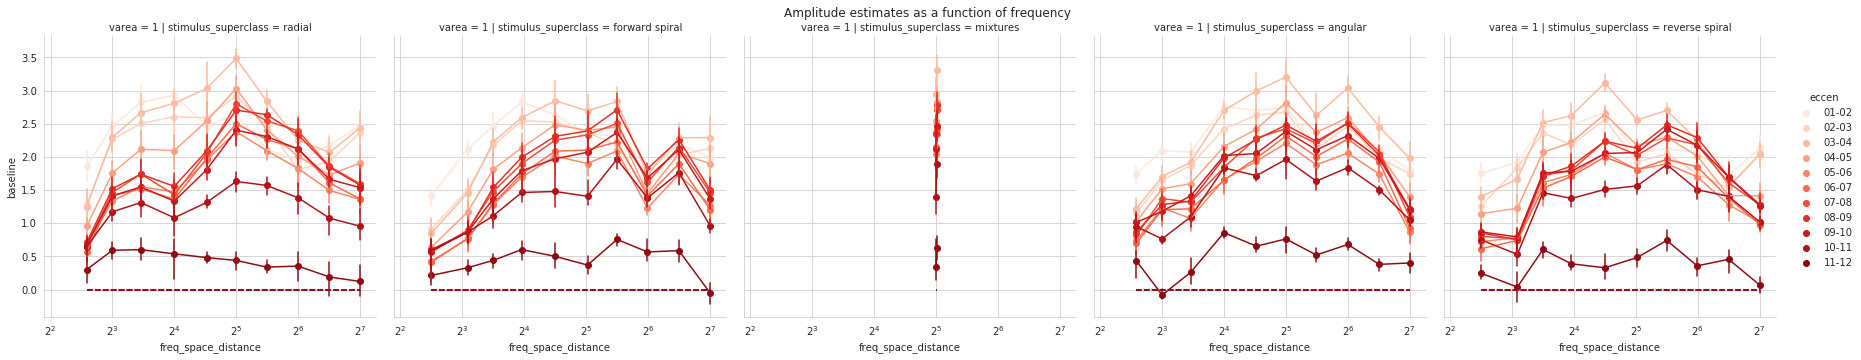

In [5]:
with sns.axes_style('whitegrid'):
    sfp.plotting.plot_data(full_ds['df'])


In [25]:
import re
joined_df = []
for d in [full_ds, full_ds_old, full_ds_new]:
    ses = re.search(r'(ses-[0-9]+)_', d['df_filename']).groups()[0]
    df = d['df'].copy()
    df['session'] = ses
    joined_df.append(df)
joined_df = pd.concat(joined_df)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


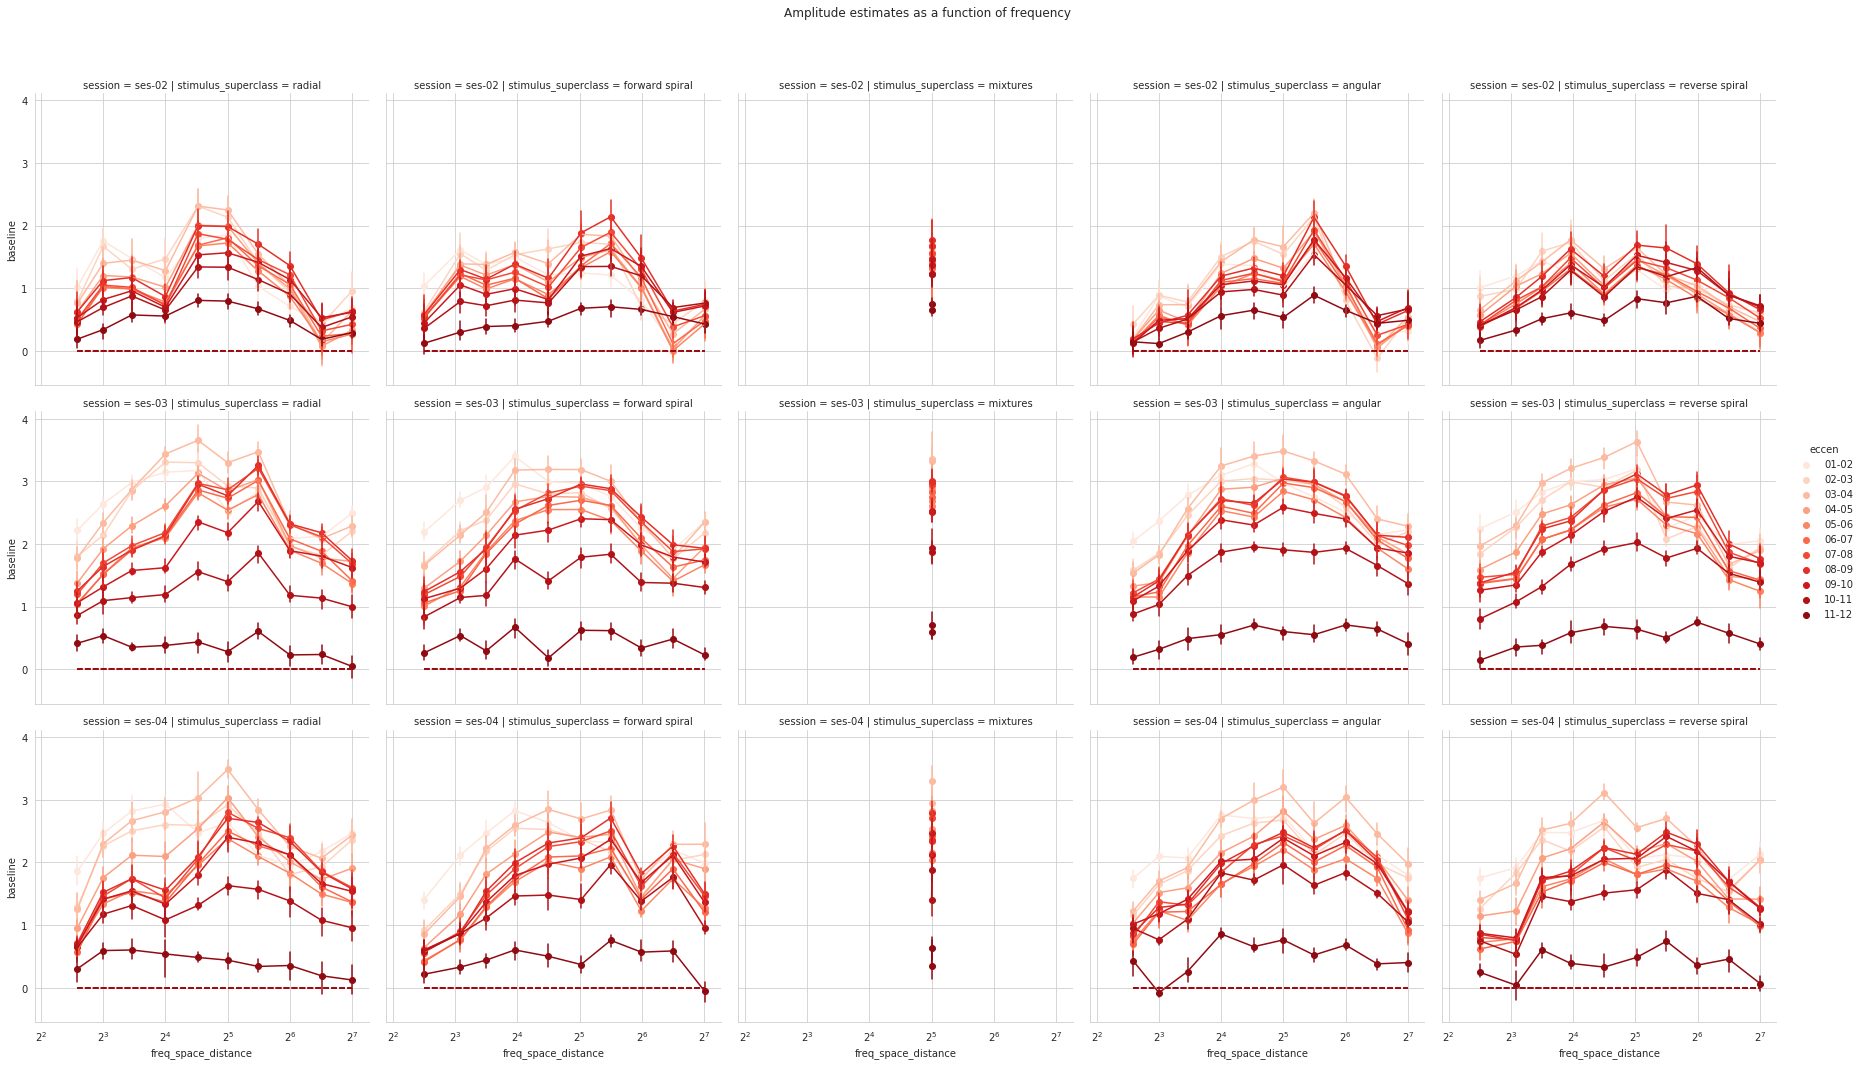

In [33]:
with sns.axes_style('whitegrid'):
    sfp.plotting.plot_data(joined_df, row='session',)


/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


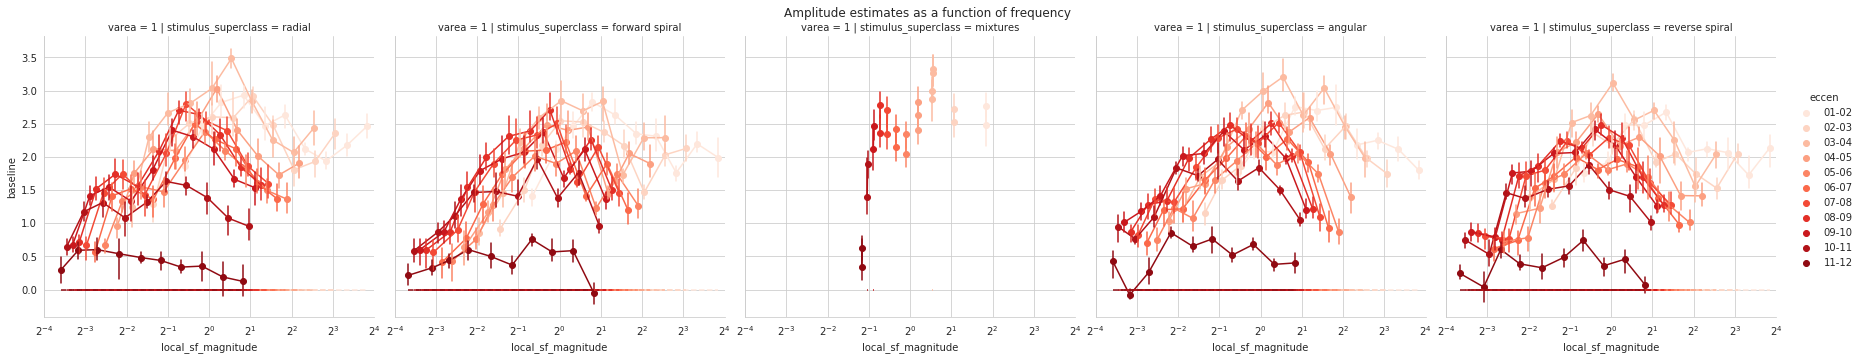

In [8]:
with sns.axes_style('whitegrid'):
    sfp.plotting.plot_data(full_ds['df'], 'local_sf_magnitude', xlim=(2**-4, 2**4))


/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


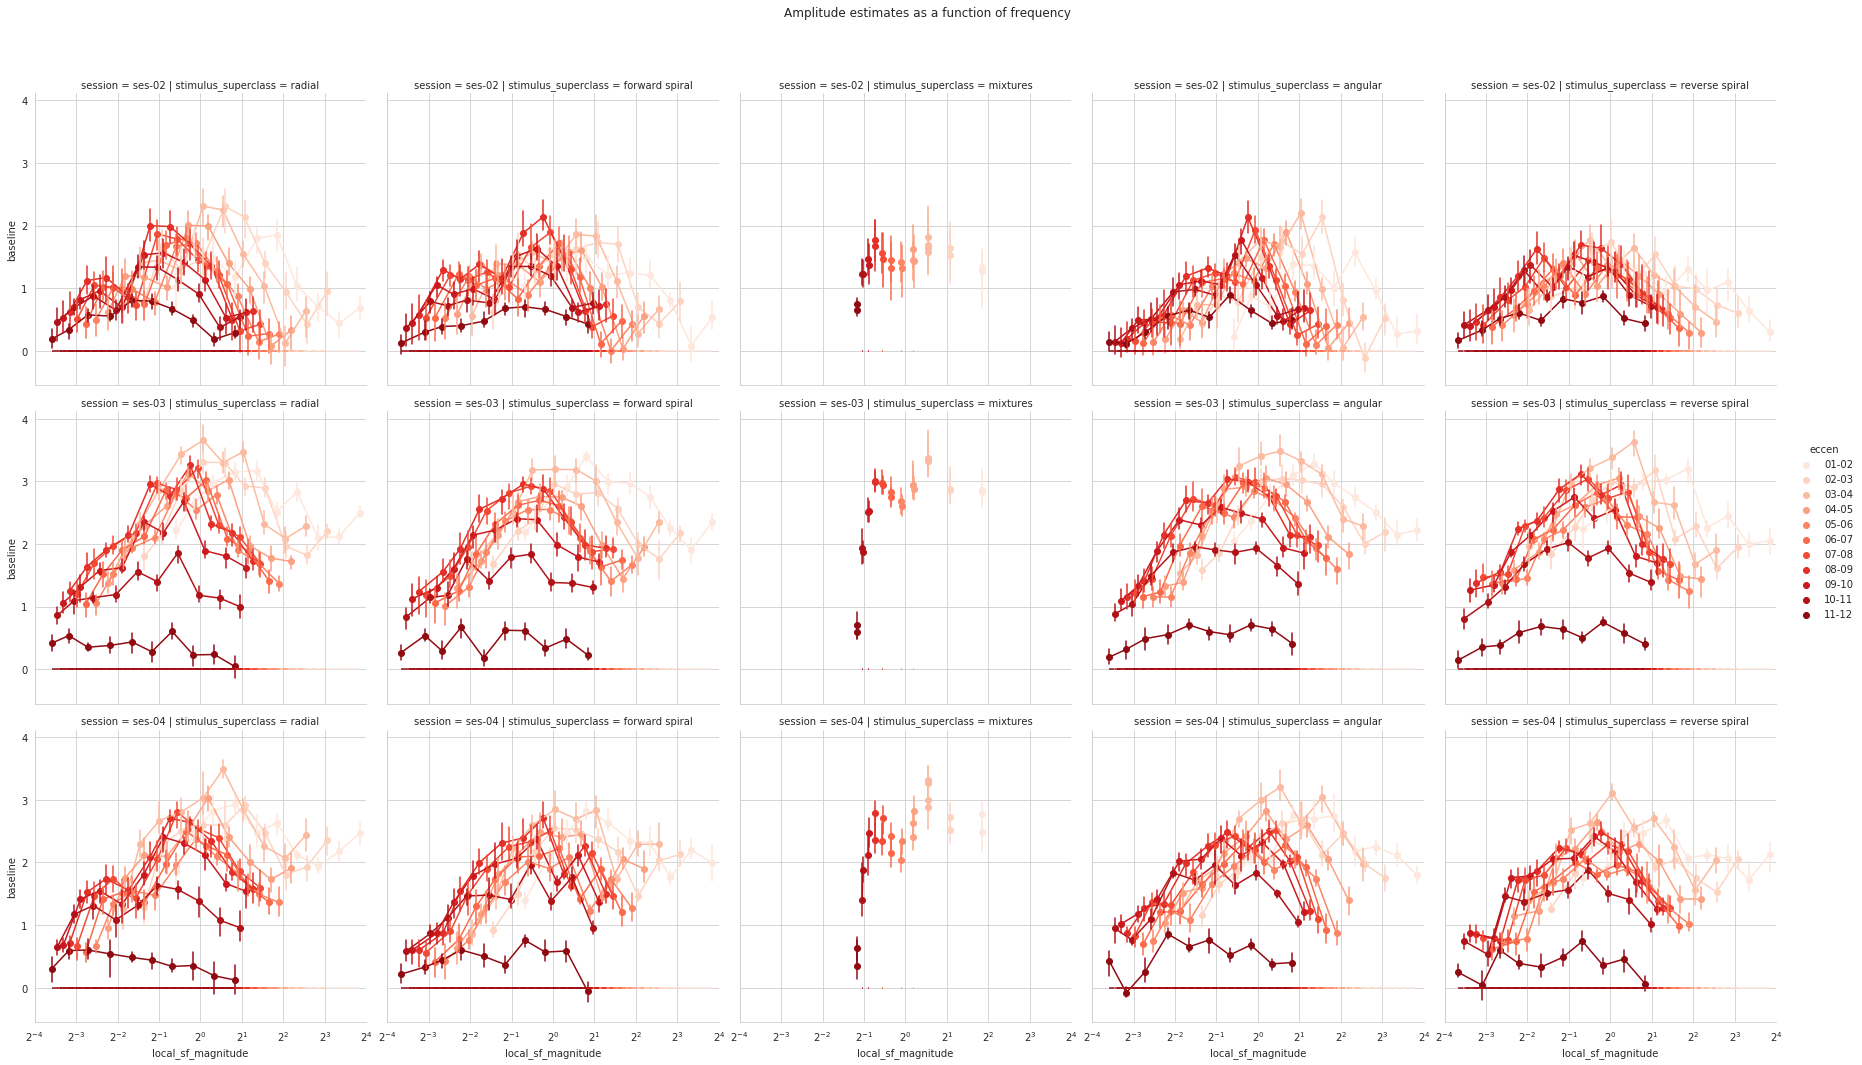

In [34]:
with sns.axes_style('whitegrid'):
    sfp.plotting.plot_data(joined_df, 'local_sf_magnitude', row='session', xlim=(2**-4, 2**4))


This shows a similar reduced view of the (V1) data with tuning curves. We only show the tuning curves fit to the median bootstrap, but we fit a separate tuning curve to each bootstrap

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


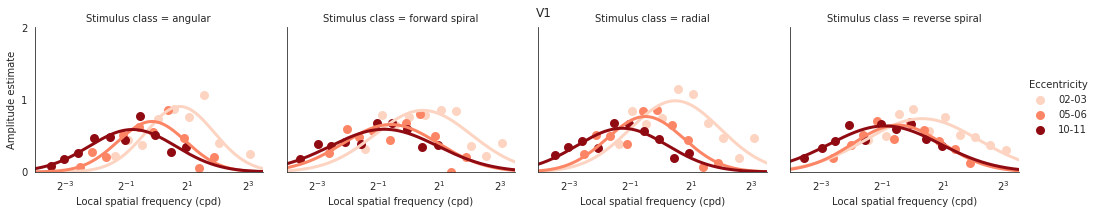

In [13]:
tuning_curve = ds['tuning_df']
tuning_curve = tuning_curve[(tuning_curve.varea==1)&(tuning_curve.eccen.isin(['02-03', '05-06', '10-11']))&(tuning_curve.stimulus_superclass.isin(['radial', 'angular', 'forward spiral', 'reverse spiral']))
                            &(tuning_curve.frequency_type=="local_sf_magnitude")]

palette = [sns.color_palette("Reds", 11)[1]] + [sns.color_palette("Reds", 11)[4]] + [sns.color_palette("Reds", 11)[10]]
with sns.axes_style('white'):
    g = sns.FacetGrid(tuning_curve, hue='eccen', palette=palette, size=3, col='stimulus_superclass', xlim=(2**-4, 2**3.5), ylim=(0,4), aspect=1.2)
    g.map_dataframe(sfp.plotting.plot_tuning_curve, linewidth=3)
    g.map(plt.scatter, 'frequency_value', 'amplitude_estimate', linewidth=3)
    g.set_yticklabels([0, '', 1, '', 2, '', 3, '', 4])
    g.set(xticks=[2**-3, 2**-1, 2**1, 2**3])
    g.add_legend()
    g._legend.set_title("Eccentricity")
    g.set_xlabels("Local spatial frequency (cpd)")
    g.set_ylabels("Amplitude estimate")
    g.set_titles("Stimulus class = {col_name}")
    g.fig.suptitle("V1")

We can also look at many of these at once, as in the following.

Here, as above, we plot the different stimulus classes in different columns, with colors representing the different eccentricities (and only showing data from V1). Now, the points represent the median, but the tuning curve shows a shaded region showing the 68% confidence interval.

The two rows show two different values along the x-axes. In the top, the x-axis shows the local spatial frequency, whereas the bottom has the frequency space distance along the x-axis. The two extreme possibilities given earlier, constant and scaling, give two different ways this data could look. If the constant hypothesis is correct, then the tuning curves at different eccentricities will all look basically identical when plotted as a function of the local spatial frequency. If, on the other hand, the scaling one is correct, then they'll line up when plotted as a function of the frequency space distance.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


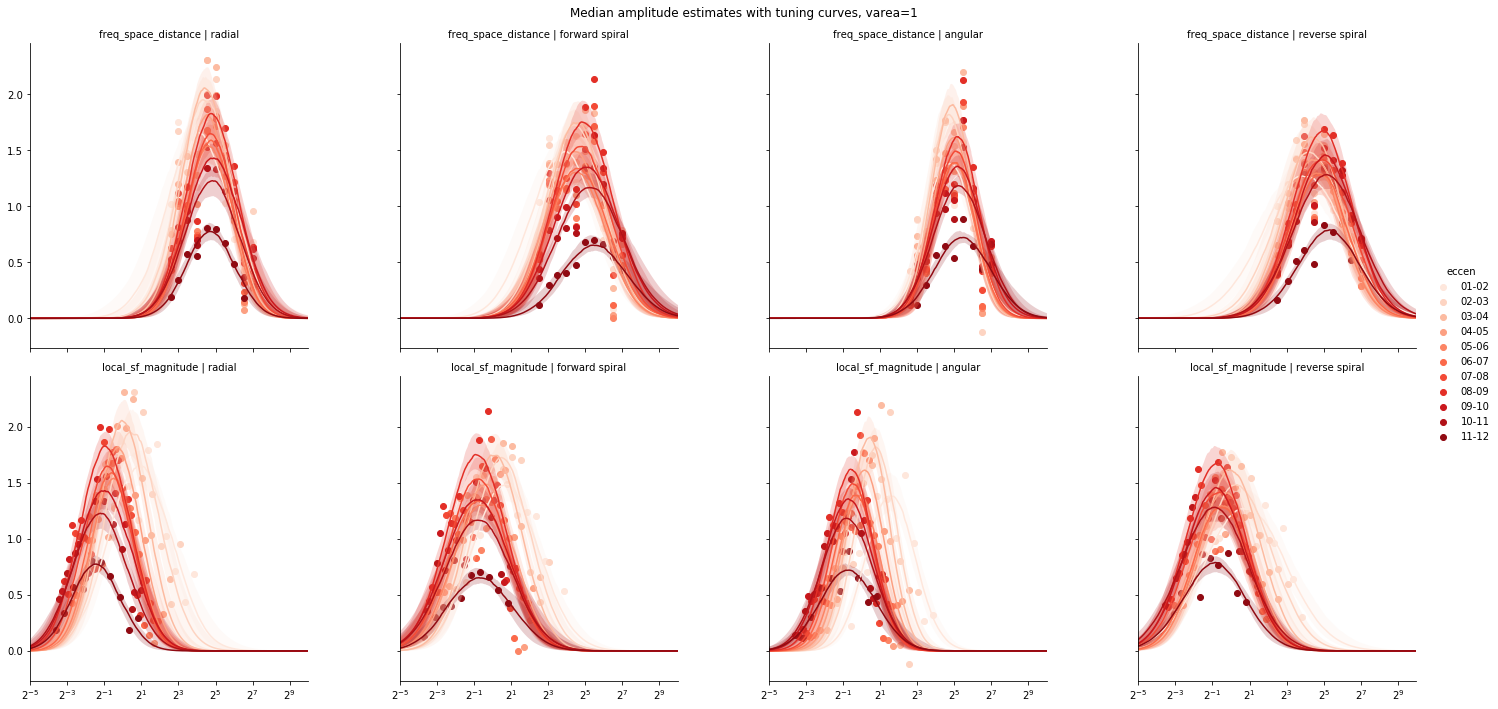

In [14]:
sfp.plotting.check_hypotheses_with_data(full_ds['tuning_df'], varea=1)

It's a little hard to see what's going on above, so now we'll remove the data points and normalize the heights of all the tuning curves. The same predictions apply.

We can see that the tuning curves don't line up exactly in either row (though they're closer in the top one). We'll return to this later on when we look across subjects.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


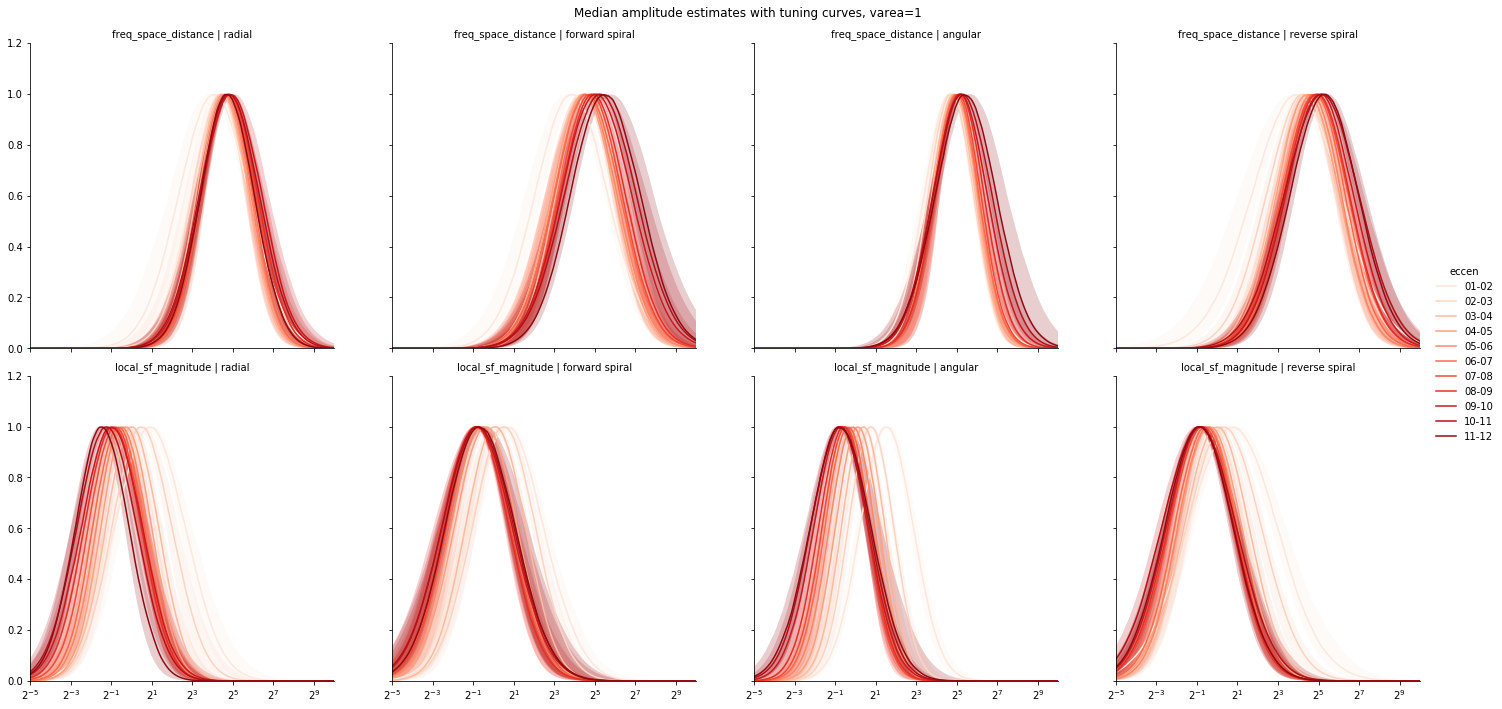

In [15]:
sfp.plotting.check_hypotheses_normalized(full_ds['tuning_df'], varea=1)

# Looking across subjects

Now that we have the tuning curves, we can examine their parameters and properties across subjects in order to see if we can find any orderly pattern. In order to do that, we load in the dataframe summarizing all these tuning curves

In [5]:
df = pd.read_csv(os.path.join(bids_dir, 'derivatives/tuning_curves_summary/stim_class/posterior/v1_e1-12_eccen_bin_tuning_curves_full.csv'))

In order to make things simple, we plot the preferred period (the reciprocal of the tuning curve peak / preferred spatial frequency). In this representation, the scaling possibility would give us a straight line through the origin. We show the preferred period as a function of eccentricity, for the five subjects separately, with colors showing the different stimulus classes.

We see that the preferred period grows linearly, but the fit would not go through the origin.

Also, two subjects are incredibly noisy.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


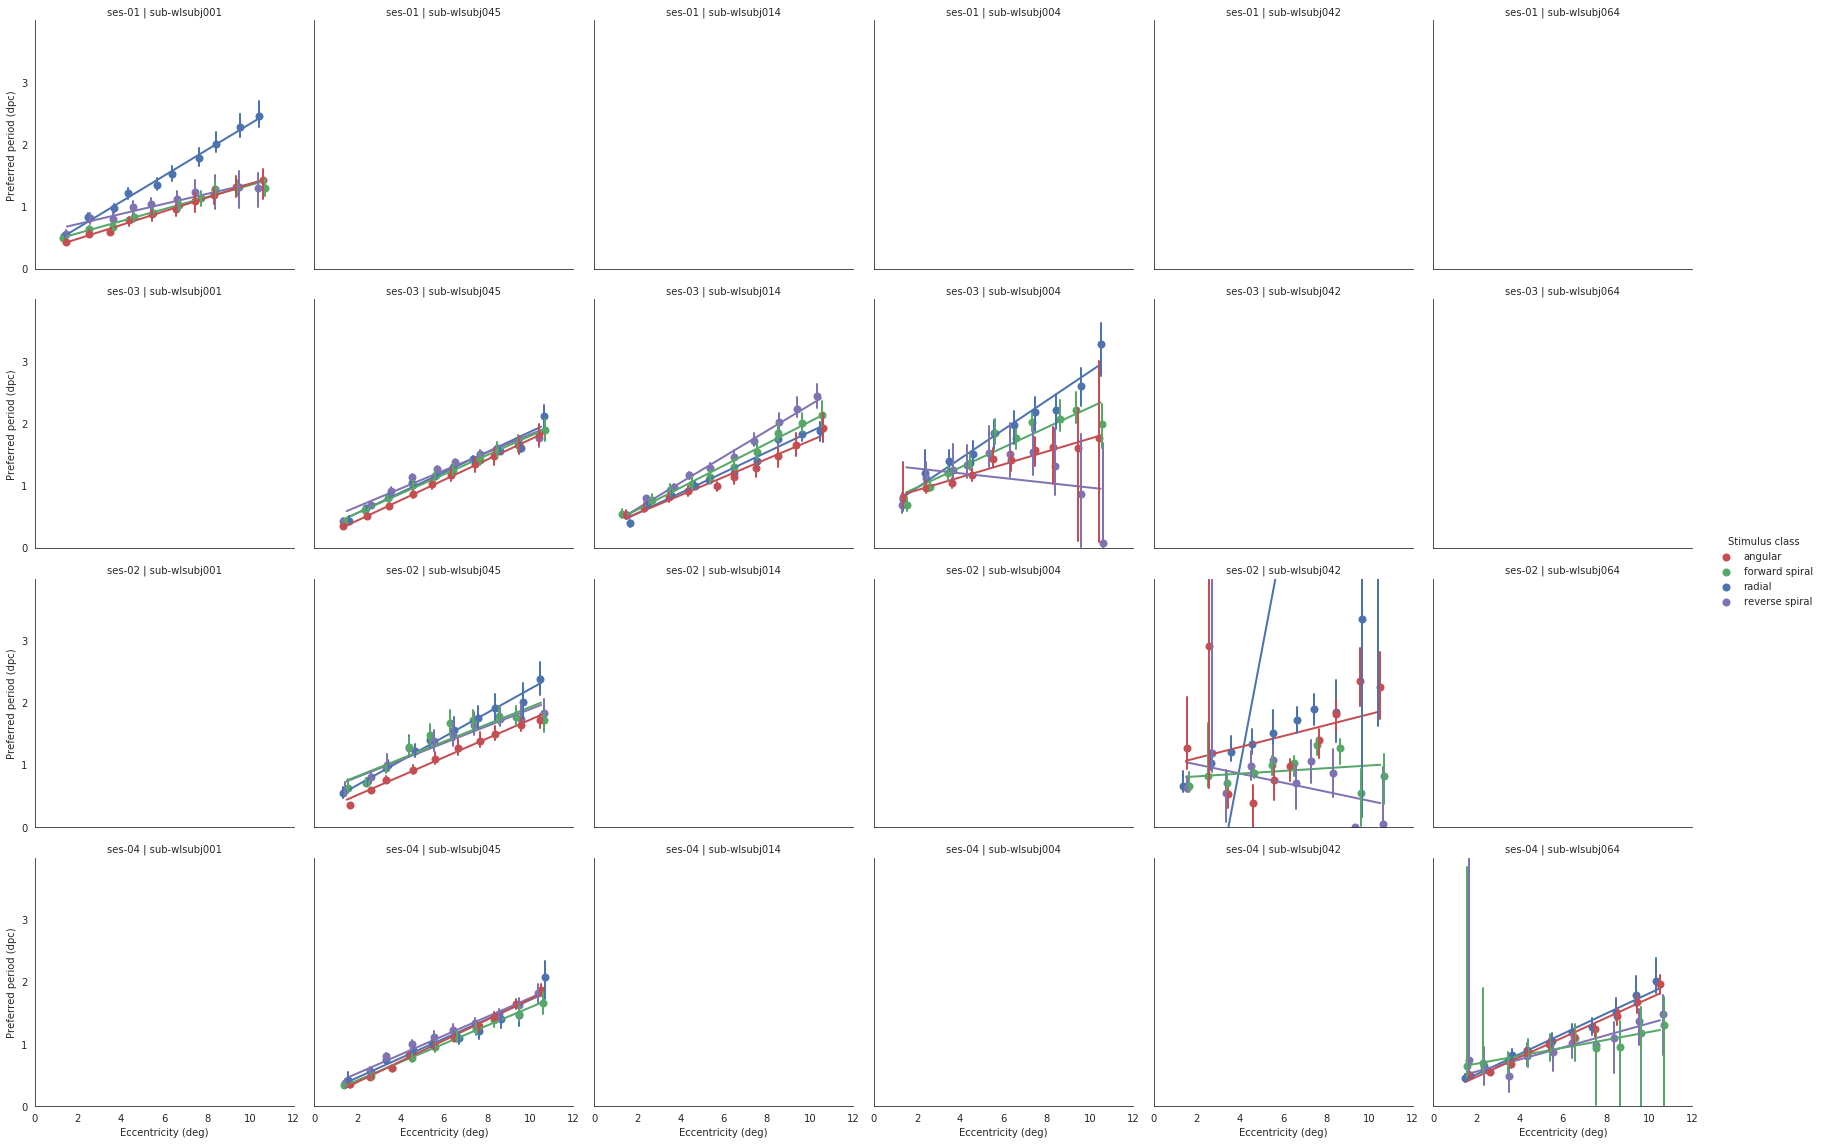

In [7]:
pal = sns.palettes.color_palette('deep', 5)
pal = {'radial': pal[0], 'reverse spiral': pal[4], 'forward spiral': pal[2], 'angular': pal[3], 'mixtures': pal[1]}
hue_order = ['radial', 'reverse spiral', 'forward spiral', 'angular', 'mixtures']
g = sfp.summary_plots.main(df, row='session', col='subject', task=['task-sfp', 'task-sfprescaled'], session=['ses-01', 'ses-02', 'ses-03', 'ses-04'], y='preferred_period', varea=1, frequency_type='local_sf_magnitude', eccen_range=(0, 11),
                       plot_func=[sfp.plotting.plot_median_fit, sfp.plotting.scatter_ci_dist], xlim=(0,12), ylim=(0,4), axes_style='white', x_jitter=[None, .2],
                       col_order=['sub-wlsubj001', 'sub-wlsubj045', 'sub-wlsubj014', 'sub-wlsubj004', 'sub-wlsubj042', 'sub-wlsubj064'], size=4, palette=pal, hue_order=hue_order, linewidth=2)
g.set_ylabels('Preferred period (dpc)')
g.set_xlabels('Eccentricity (deg)')
g.set(yticks=[0,1,2,3])
g._legend.set_title("Stimulus class")
#for i, ax in enumerate(g.axes):
#    ax.tick_params(size=0)
#    ax.set_title("Subject %d" % (i+1))
#g.fig.savefig('allsubj.svg')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


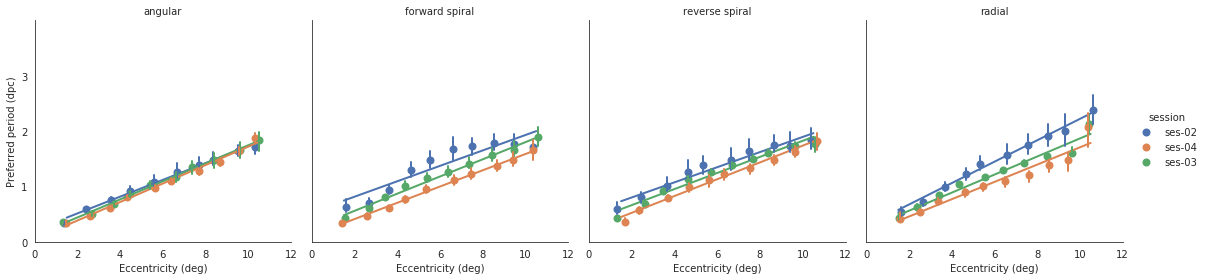

In [39]:
g = sfp.summary_plots.main(df, hue='session', row=None, col='stimulus_superclass', task=['task-sfp', 'task-sfprescaled'], subject=['sub-wlsubj045'], session=['ses-01', 'ses-02', 'ses-03', 'ses-04'],
                           y='preferred_period', varea=1, frequency_type='local_sf_magnitude', eccen_range=(0, 11),
                           plot_func=[sfp.plotting.plot_median_fit, sfp.plotting.scatter_ci_dist], xlim=(0,12), ylim=(0,4), axes_style='white', x_jitter=[None, .2],
                           col_order=['angular', 'forward spiral', 'reverse spiral', 'radial'], size=4, palette='deep', linewidth=2,)
g.set_ylabels('Preferred period (dpc)')
g.set_xlabels('Eccentricity (deg)')
g.set(yticks=[0,1,2,3])
#for i, ax in enumerate(g.axes):
#    ax.tick_params(size=0)
#    ax.set_title("Subject %d" % (i+1))
#g.fig.savefig('allsubj.svg')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


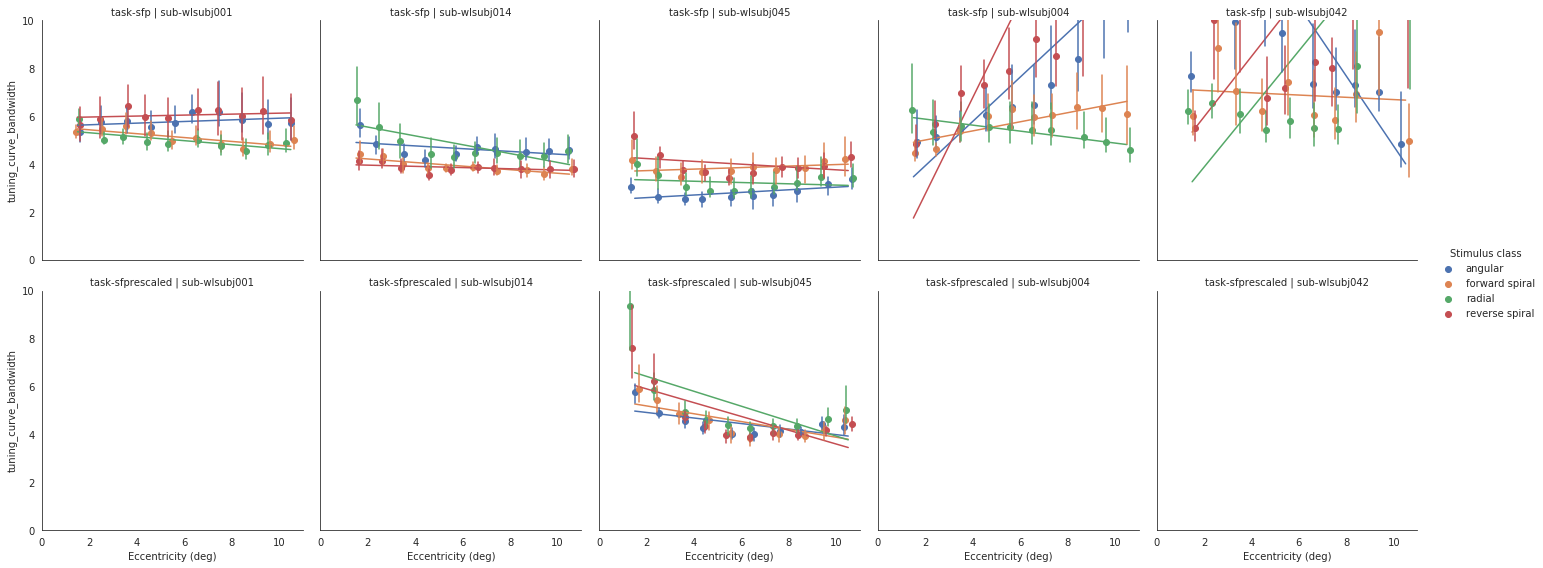

In [65]:
pal = [sns.color_palette('deep', 4)[0]] + [sns.color_palette('deep', 4)[2]]
g = sfp.summary_plots.main(df, row='task', col='subject', task=['task-sfp', 'task-sfprescaled'], session=['ses-01', 'ses-02', 'ses-03', 'ses-04'], y='tuning_curve_bandwidth', varea=1, frequency_type='local_sf_magnitude', eccen_range=(0, 11),
                       plot_func=[sfp.plotting.plot_median_fit, sfp.plotting.scatter_ci_dist], xlim=(0,11), axes_style='white', x_jitter=[None, .2],
                       col_order=['sub-wlsubj001', 'sub-wlsubj014', 'sub-wlsubj045', 'sub-wlsubj004', 'sub-wlsubj042'], size=4, palette='deep')
# g.set_ylabels('Preferred period (dpc)')
g.set_xlabels('Eccentricity (deg)')
#g.set(yticks=[0,1,2,3])
g._legend.set_title("Stimulus class")

For some subjects, we did these measurements using constant, full-field gratings as well. You get similar numbers, but the error bars are much larger, because the data is noisier.

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


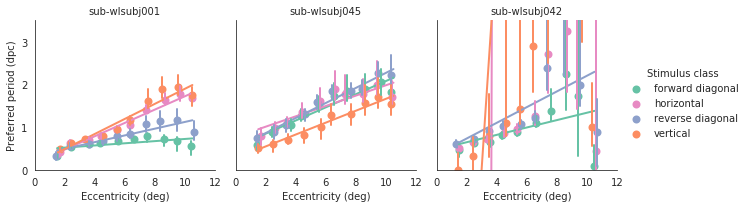

In [21]:
pal = sns.palettes.color_palette('Set2', 4)
pal = dict((k, v) for k, v in zip(['forward diagonal', 'vertical', 'reverse diagonal', 'horizontal'], pal))
g = sfp.summary_plots.main(df, row=None, col='subject', task='task-sfpconstant', session=['ses-01', 'ses-02', 'ses-03'], y='preferred_period', varea=1, frequency_type='local_sf_magnitude', eccen_range=(0, 11),
                       plot_func=[sfp.plotting.plot_median_fit, sfp.plotting.scatter_ci_dist], xlim=(0,12), ylim=(0,3.5), col_wrap=3, axes_style='white', x_jitter=[None, .2],
                       col_order=['sub-wlsubj001', 'sub-wlsubj045', 'sub-wlsubj042'], size=3, palette=pal, linewidth=2)
g.set_ylabels('Preferred period (dpc)')
g.set_xlabels('Eccentricity (deg)')
g.set(yticks=[0,1,2,3])
g._legend.set_title("Stimulus class")
#for i, ax in zip([1,2,5], g.axes):
#    ax.tick_params(size=0)
#    ax.set_title("Subject %d" % i)
#g.fig.savefig('allsubj-constant.svg')

To summarize, let's combine across subjects. We do this by taking the median across bootstraps for each subject and then the weighted average across subjects (where the weight is the inverse of the size of the 68% confidence interval, in order to give us a sense of the precision of each subject's data).

We then plot the best fit line to each stimulus class, showing where the intercept would be using a dotted line.

In [8]:
final_df = df[(df['task'].isin(['task-sfp']))&(df.varea==1)&(df.session.isin(['ses-01', 'ses-02', 'ses-03', 'ses-04']))&(df.frequency_type=='local_sf_magnitude')&(df.eccen<11)]
final_df = final_df[['eccen', 'preferred_period', 'stimulus_superclass', 'subject', 'bootstrap_num']]
tmp_df = final_df.groupby(['subject', 'stimulus_superclass', 'eccen',])['preferred_period'].apply(np.percentile, [16, 84]).apply(lambda x: (abs(x[1]-x[0])/2)**2).reset_index(name='precision')
final_df = final_df.groupby(['eccen', 'stimulus_superclass', 'subject',])['preferred_period'].median().reset_index(name='preferred_period')
final_df = final_df.set_index(['subject', 'stimulus_superclass',])
final_df['precision'] = tmp_df.groupby(['subject', 'stimulus_superclass',]).precision.mean()
final_df = final_df.reset_index()
final_df = final_df.groupby(['stimulus_superclass', 'eccen',]).apply(lambda x: np.average(x.preferred_period, weights=1./x.precision)).reset_index(name='preferred_period')

In [40]:
coefs = []
ints = []
for n,g in final_df.groupby('stimulus_superclass'):
    plot_data = g.groupby('eccen')['preferred_period'].median()
    model = linear_model.LinearRegression(True)
    model.fit(plot_data.index.values.reshape(-1, 1), plot_data.values)
    coefs.append(model.coef_)
    ints.append(model.intercept_)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


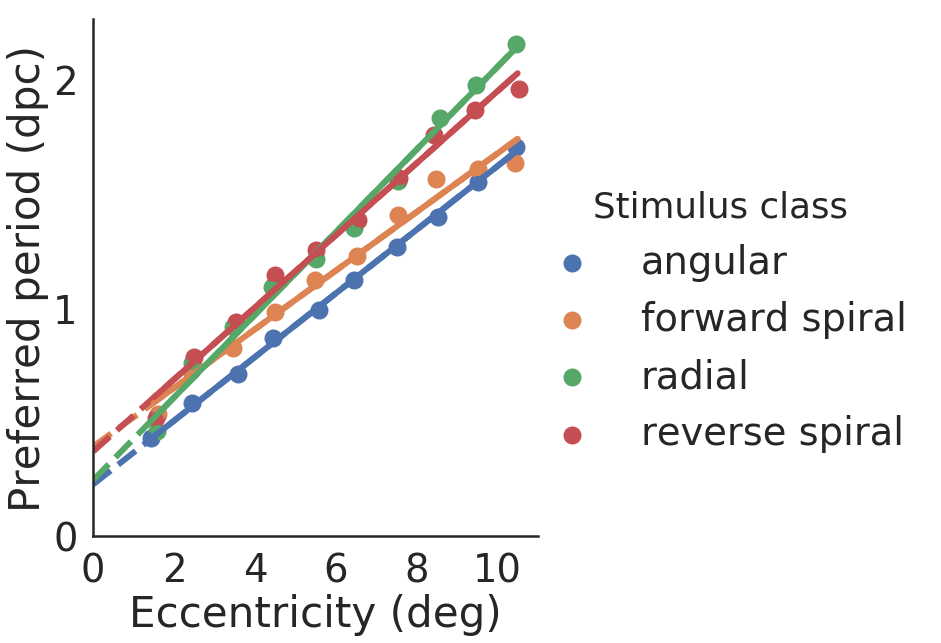

In [9]:
with sns.plotting_context('poster', font_scale=1.75), sns.axes_style('white'):
    g = sns.FacetGrid(final_df, hue='stimulus_superclass', size=10, palette='deep', xlim=(0, 11))
    g.map_dataframe(sfp.plotting.scatter_ci_dist, 'eccen', 'preferred_period', ci_vals=[50,50], x_jitter=True,marker='o', linewidth=6)
    g.map_dataframe(sfp.plotting.plot_median_fit, 'eccen', 'preferred_period', linear_model.LinearRegression(True), linewidth=6, x_vals=(0, 10.5), linestyle='--')
    g.map_dataframe(sfp.plotting.plot_median_fit, 'eccen', 'preferred_period', linear_model.LinearRegression(True), linewidth=6)
    g.set(yticks=[0, 1, 2])
    g.add_legend()
    g._legend.set_title('Stimulus class')
    g.set_xlabels("Eccentricity (deg)")
    g.set_ylabels("Preferred period (dpc)")

In [14]:
final_df = df[(df['task'].isin(['task-sfprescaled']))&(df.varea==1)&(df.session.isin(['ses-01', 'ses-02', 'ses-03', 'ses-04']))&(df.frequency_type=='local_sf_magnitude')&(df.eccen<11)]
final_df = final_df[['eccen', 'preferred_period', 'stimulus_superclass', 'subject', 'bootstrap_num']]
tmp_df = final_df.groupby(['subject', 'stimulus_superclass', 'eccen',])['preferred_period'].apply(np.percentile, [16, 84]).apply(lambda x: (abs(x[1]-x[0])/2)**2).reset_index(name='precision')
final_df = final_df.groupby(['eccen', 'stimulus_superclass', 'subject',])['preferred_period'].median().reset_index(name='preferred_period')
final_df = final_df.set_index(['subject', 'stimulus_superclass',])
final_df['precision'] = tmp_df.groupby(['subject', 'stimulus_superclass',]).precision.mean()
final_df = final_df.reset_index()
final_df = final_df.groupby(['stimulus_superclass', 'eccen',]).apply(lambda x: np.average(x.preferred_period, weights=1./x.precision)).reset_index(name='preferred_period')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


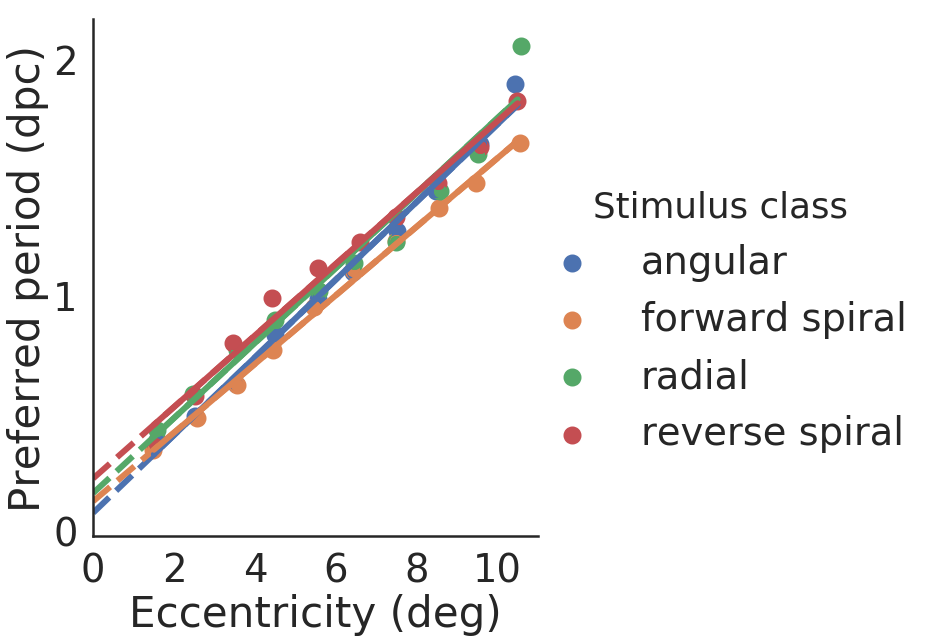

In [15]:
with sns.plotting_context('poster', font_scale=1.75), sns.axes_style('white'):
    g = sns.FacetGrid(final_df, hue='stimulus_superclass', size=10, palette='deep', xlim=(0, 11))
    g.map_dataframe(sfp.plotting.scatter_ci_dist, 'eccen', 'preferred_period', ci_vals=[50,50], x_jitter=True,marker='o', linewidth=6)
    g.map_dataframe(sfp.plotting.plot_median_fit, 'eccen', 'preferred_period', linear_model.LinearRegression(True), linewidth=6, x_vals=(0, 10.5), linestyle='--')
    g.map_dataframe(sfp.plotting.plot_median_fit, 'eccen', 'preferred_period', linear_model.LinearRegression(True), linewidth=6)
    g.set(yticks=[0, 1, 2])
    g.add_legend()
    g._legend.set_title('Stimulus class')
    g.set_xlabels("Eccentricity (deg)")
    g.set_ylabels("Preferred period (dpc)")

We can also do one more way of looking at this. Since we have the lines that tell us the size of our pRF as a function of eccentricity (from Benson et al, 2018, the HCP 7T retinotopy dataset) and the above gives us lines to get the preferred period at each eccentricity, we can figure out the optimal number of cycles to have in our pRF at each eccentricity (separately for each stimulus class). If the above line and the pRF size line had the same intercept, this would be the same at each eccentricity (because the ratios would be constant). Since they don't, it varies slightly, but not by much.

The `Approx_cycles_per_2_pRF_sigma` gives the approximate number of cycles of each stimulus class that we'd have within two sigmas of our pRF, just based on the slopes of the line.

In [26]:
# From Benson et al, HCP 7T retinotopy data. They do not have a non-zero intercept and therefore we cannot directly do this comparison
# This is one sigma
V1_pRF_sigma = .063485
# For our purposes, we want to know the number of periods we have in a circle with 2 sigmas. For this to work, we need V1_pRF_sigma*2*2 (to get diameter, and then two sigmas)
V1_pRF_coef = V1_pRF_sigma * 4

def fit_model(data, model=linear_model.LinearRegression()):
    x = data.eccen.values
    y = data.preferred_period.values
    model.fit(x.reshape(-1, 1), y)
    return pd.Series({'coeff': model.coef_[0], 'intercept': model.intercept_})
model_df = final_df.groupby('stimulus_superclass').apply(fit_model)
model_df['Approx_cycles_per_2_pRF_sigma'] = V1_pRF_coef / model_df['coeff']

model_df

,coeff,intercept,Approx_cycles_per_2_pRF_sigma
stimulus_superclass,,,
angular,0.138948,0.240546,1.827591
forward spiral,0.128006,0.424942,1.983809
radial,0.184056,0.250746,1.379690
reverse spiral,0.159032,0.390217,1.596781


We can visualize this (the exact results) as follows below. We now have apertures at several different eccentricities, showing windowed views of the optimal stimulus at that eccentricity. We can see that it looks like about 1.5 or 2 cycles in each view.

The different angles correspond to different stimulus types. Clockwise from the top: circular, reverse spiral, forward spiral, radial.

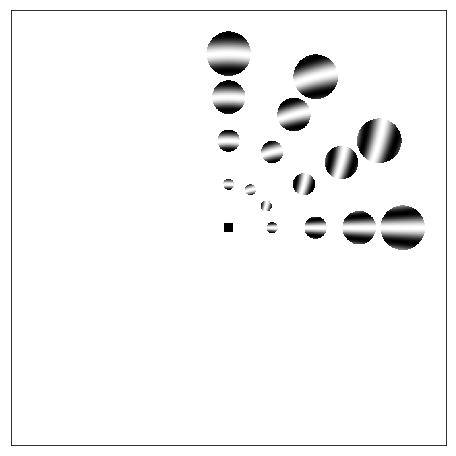

In [27]:
_=sfp.plotting.period_summary_plot(final_df, center_spot_rad=10, size=1080, plot_view='quarter')